## import library and load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(33)

In [2]:

# Load Train data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['Activity'])

# Load Test data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['Activity'])

# Load feature names
feature_names = pd.read_csv('UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['index', 'feature'])
X_train.columns = feature_names['feature'].values
X_test.columns = feature_names['feature'].values

# Load activity names
activity_labels = pd.read_csv('UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, names=['code', 'activity'])


print(f"\n X_train Shape: {X_train.shape}")
print(f" y_train Shape: {y_train.shape}")
print(f" X_test Shape: {X_test.shape}")
print(f" y_test Shape: {y_test.shape}")



 X_train Shape: (7352, 561)
 y_train Shape: (7352, 1)
 X_test Shape: (2947, 561)
 y_test Shape: (2947, 1)


In [3]:

print("\n Activity names:")
print(activity_labels)

print("\n Distribution of classes in Train:")
train_dist = y_train['Activity'].value_counts().sort_index()
for idx, count in train_dist.items():
    activity_name = activity_labels[activity_labels['code'] == idx]['activity'].values[0]
    print(f"   Class {idx} ({activity_name}): {count} Sample ({count/len(y_train)*100:.1f}%)")

print("\n Distribution of classes in Test:")
test_dist = y_test['Activity'].value_counts().sort_index()
for idx, count in test_dist.items():
    activity_name = activity_labels[activity_labels['code'] == idx]['activity'].values[0]
    print(f"   Class {idx} ({activity_name}): {count} Sample ({count/len(y_test)*100:.1f}%)")


print(X_train.describe())

print("\n Checking for missing values:")
print(f" Number of NaNs in X_train: {X_train.isna().sum().sum()}")
print(f" Number of NaNs in X_test: {X_test.isna().sum().sum()}")



 Activity names:
   code            activity
0     1             WALKING
1     2    WALKING_UPSTAIRS
2     3  WALKING_DOWNSTAIRS
3     4             SITTING
4     5            STANDING
5     6              LAYING

 Distribution of classes in Train:
   Class 1 (WALKING): 1226 Sample (16.7%)
   Class 2 (WALKING_UPSTAIRS): 1073 Sample (14.6%)
   Class 3 (WALKING_DOWNSTAIRS): 986 Sample (13.4%)
   Class 4 (SITTING): 1286 Sample (17.5%)
   Class 5 (STANDING): 1374 Sample (18.7%)
   Class 6 (LAYING): 1407 Sample (19.1%)

 Distribution of classes in Test:
   Class 1 (WALKING): 496 Sample (16.8%)
   Class 2 (WALKING_UPSTAIRS): 471 Sample (16.0%)
   Class 3 (WALKING_DOWNSTAIRS): 420 Sample (14.3%)
   Class 4 (SITTING): 491 Sample (16.7%)
   Class 5 (STANDING): 532 Sample (18.1%)
   Class 6 (LAYING): 537 Sample (18.2%)
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695   

### Visualizing class distribution

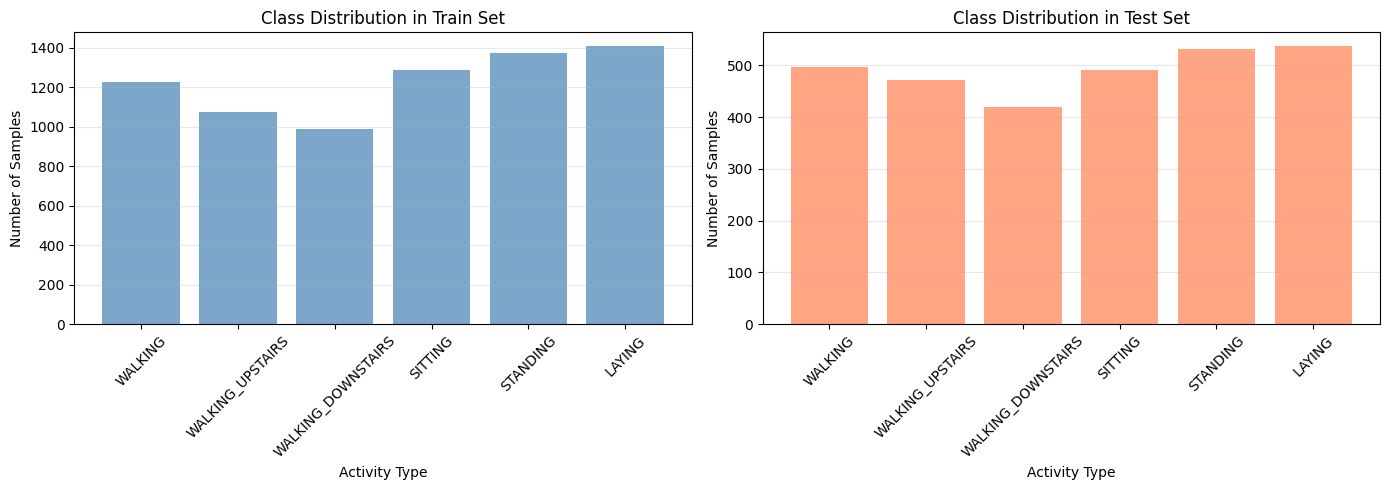

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
activity_names_train = [activity_labels[activity_labels['code'] == i]['activity'].values[0] for i in train_dist.index]
axes[0].bar(activity_names_train, train_dist.values, color='steelblue', alpha=0.7)
axes[0].set_title('Class Distribution in Train Set')
axes[0].set_xlabel('Activity Type')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Test
activity_names_test = [activity_labels[activity_labels['code'] == i]['activity'].values[0] for i in test_dist.index]
axes[1].bar(activity_names_test, test_dist.values, color='coral', alpha=0.7)
axes[1].set_title('Class Distribution in Test Set')
axes[1].set_xlabel('Activity Type')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.pdf', bbox_inches='tight')
plt.show()

## Data preprocessing

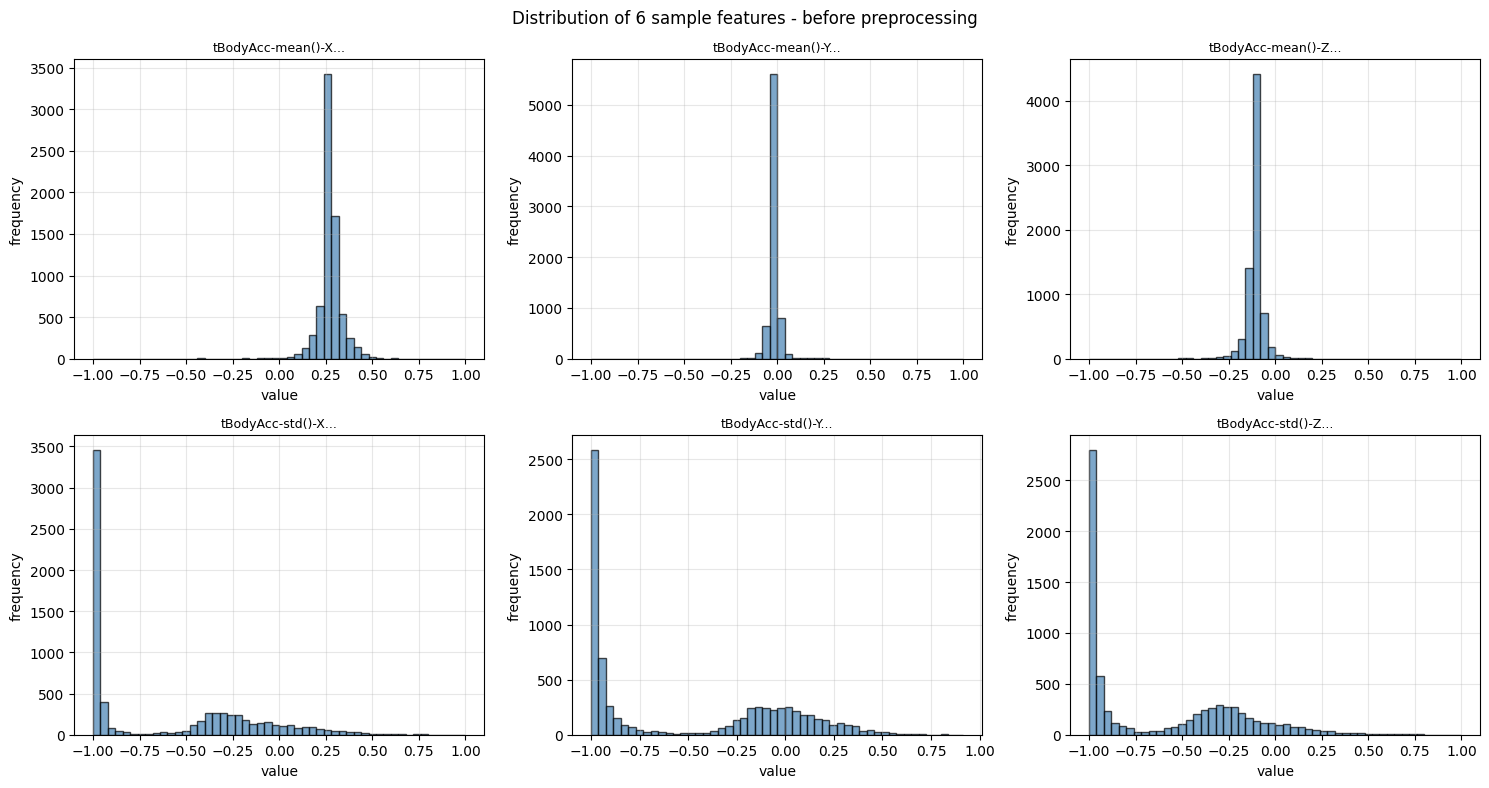

In [5]:
# Show distribution before scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribution of 6 sample features - before preprocessing')

sample_features = X_train.columns[:6]
for idx, feature in enumerate(sample_features):
    row, col = idx // 3, idx % 3
    axes[row, col].hist(X_train[feature], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{feature[:30]}...', fontsize=9)
    axes[row, col].set_xlabel('value')
    axes[row, col].set_ylabel('frequency')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_before_scaling.pdf', bbox_inches='tight')
plt.show()


### Check Outliers

In [6]:

Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR)))

outlier_count = outlier_mask.sum().sum()

print(f"Total number of Outliers in Train: {outlier_count}")
print(f" Outliers percentage: {outlier_count / (X_train.shape[0] * X_train.shape[1]) * 100:.2f}%")


Total number of Outliers in Train: 163682
 Outliers percentage: 3.97%


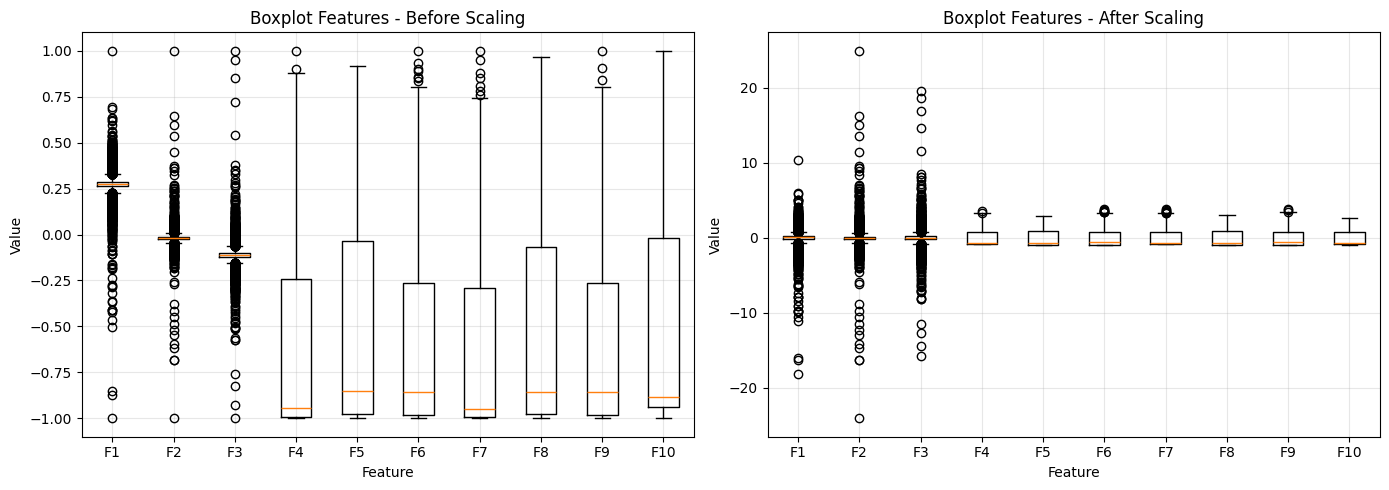

In [10]:
# Boxplot visualization to check for outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select 10 sample features
sample_features_box = X_train.columns[:10]

axes[0].boxplot([X_train[feat].values for feat in sample_features_box], 
                labels=[f'F{i+1}' for i in range(10)])
axes[0].set_title('Boxplot Features - Before Scaling')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Value')
axes[0].grid(alpha=0.3)

# Boxplot after scaling
axes[1].boxplot([X_train_scaled[feat].values for feat in sample_features_box], 
                labels=[f'F{i+1}' for i in range(10)])
axes[1].set_title('Boxplot Features - After Scaling')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Value')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('boxplot_comparison.pdf', bbox_inches='tight')
plt.show()

In [8]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f" Mean of features after scaling: {X_train_scaled.mean().mean():.6f}")
print(f" Standard deviation of features after scaling: {X_train_scaled.std().mean():.6f}")


 Mean of features after scaling: 0.000000
 Standard deviation of features after scaling: 1.000068


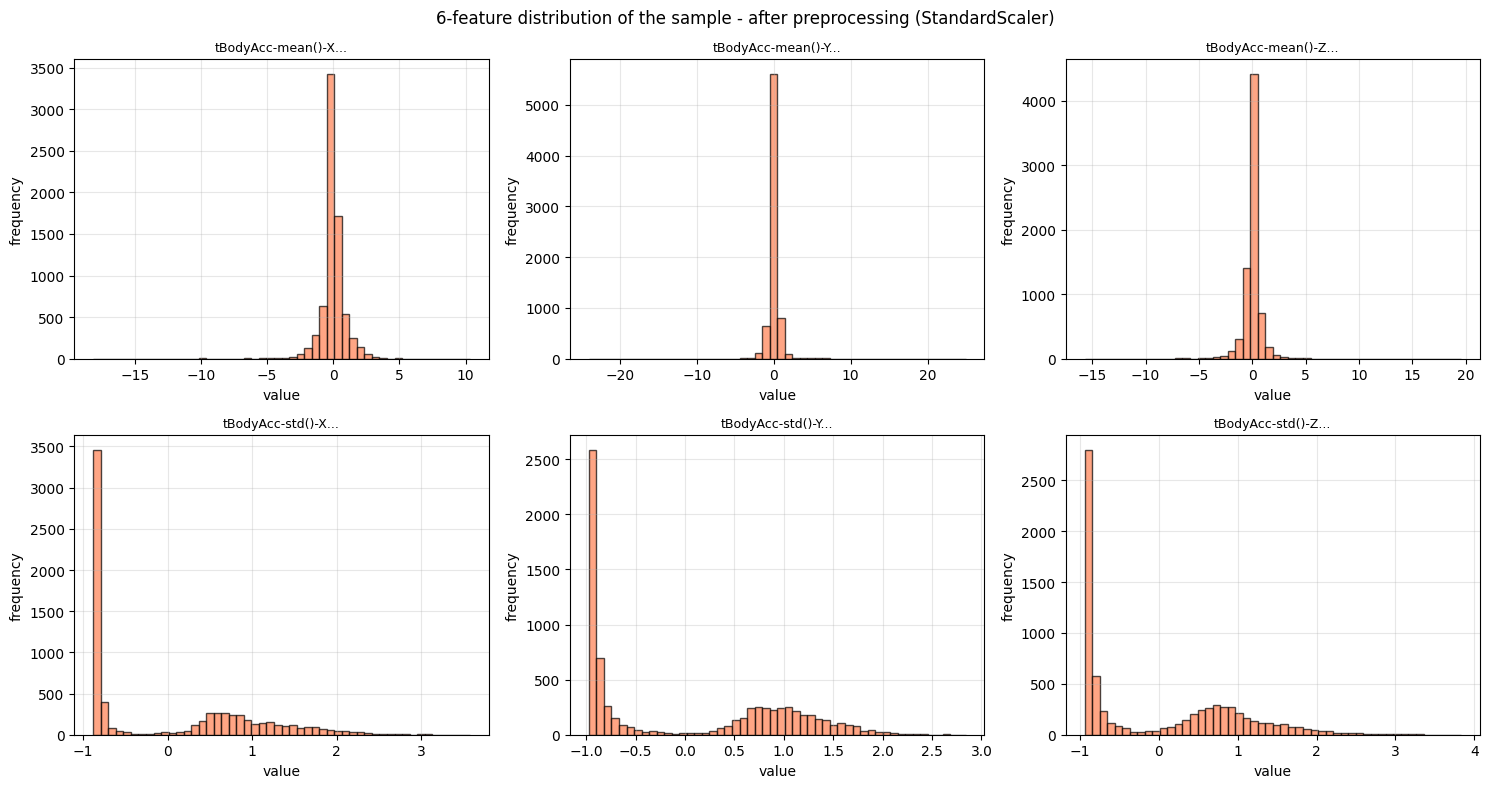

In [9]:
# Show distribution after scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('6-feature distribution of the sample - after preprocessing (StandardScaler)')
for idx, feature in enumerate(sample_features):
    row, col = idx // 3, idx % 3
    axes[row, col].hist(X_train_scaled[feature], bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{feature[:30]}...', fontsize=9)
    axes[row, col].set_xlabel('value')
    axes[row, col].set_ylabel('frequency')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_after_scaling.pdf',bbox_inches='tight')
plt.show()



## Dimension reduction

In [11]:
# Apply PCA while preserving 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=33)
X_train_pca = pca_95.fit_transform(X_train_scaled)
X_test_pca = pca_95.transform(X_test_scaled)

print(f" Number of original features: {X_train.shape[1]}")
print(f" Number of PCA components: {pca_95.n_components_}")
print(f" Variance retained: {pca_95.explained_variance_ratio_.sum():.4f} ({pca_95.explained_variance_ratio_.sum()*100:.2f}%)")
print(f" Dimensionality reduction: {X_train.shape[1] - pca_95.n_components_} Feature ({(1 - pca_95.n_components_/X_train.shape[1])*100:.1f}%)")


 Number of original features: 561
 Number of PCA components: 102
 Variance retained: 0.9508 (95.08%)
 Dimensionality reduction: 459 Feature (81.8%)


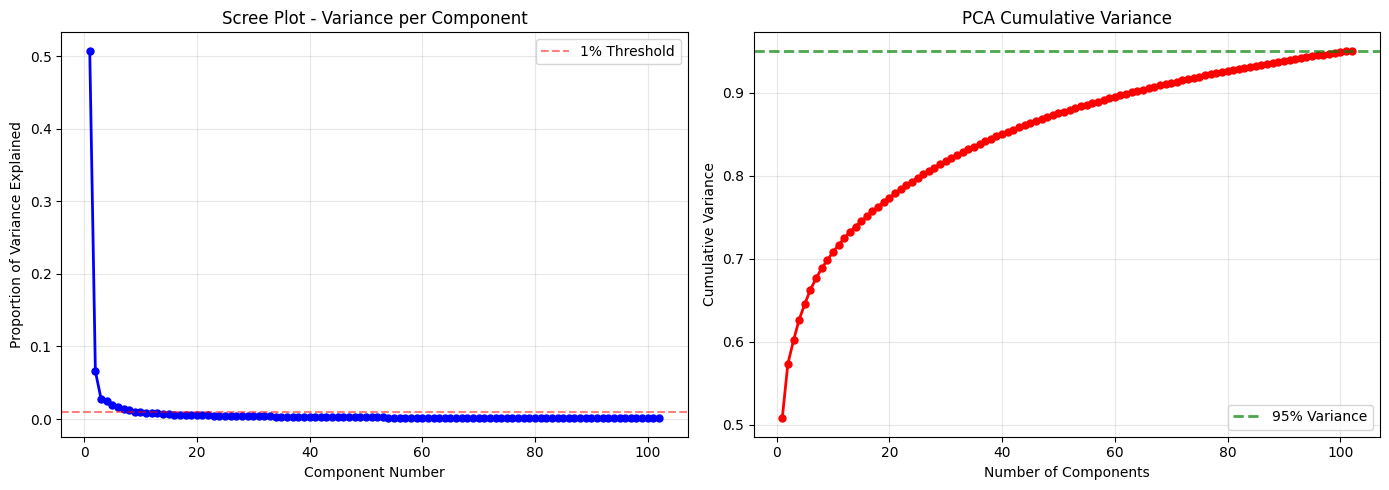

In [12]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree Plot Chart
axes[0].plot(range(1, len(pca_95.explained_variance_ratio_) + 1), 
             pca_95.explained_variance_ratio_, 'bo-', linewidth=2, markersize=5)
axes[0].set_title('Scree Plot - Variance per Component')
axes[0].set_xlabel('Component Number')
axes[0].set_ylabel('Proportion of Variance Explained')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='1% Threshold')
axes[0].legend()

# Cumulative variance chart
cumulative_variance = np.cumsum(pca_95.explained_variance_ratio_)
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2, markersize=5)
axes[1].axhline(y=0.95, color='g', linestyle='--', linewidth=2, alpha=0.7, label='95% Variance')
axes[1].set_title('PCA Cumulative Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('pca_variance_analysis.pdf',bbox_inches='tight')
plt.show()

In [13]:
# Display the first 10 components with the highest variance
print("\nThe first 10 components with the highest variance:")
for i in range(min(10, pca_95.n_components_)):
    print(f" Component {i+1}: {pca_95.explained_variance_ratio_[i]:.4f} ({pca_95.explained_variance_ratio_[i]*100:.2f}%)")


The first 10 components with the highest variance:
 Component 1: 0.5078 (50.78%)
 Component 2: 0.0658 (6.58%)
 Component 3: 0.0281 (2.81%)
 Component 4: 0.0250 (2.50%)
 Component 5: 0.0189 (1.89%)
 Component 6: 0.0172 (1.72%)
 Component 7: 0.0137 (1.37%)
 Component 8: 0.0120 (1.20%)
 Component 9: 0.0100 (1.00%)
 Component 10: 0.0097 (0.97%)


### t-SNE for 2D visualization

In [14]:
sample_size = 2000
indices = np.random.choice(X_train_pca.shape[0], size=sample_size, replace=False)
X_train_sample = X_train_pca[indices]
y_train_sample = y_train.iloc[indices]['Activity'].values

tsne = TSNE(n_components=2, random_state=33, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_train_sample)

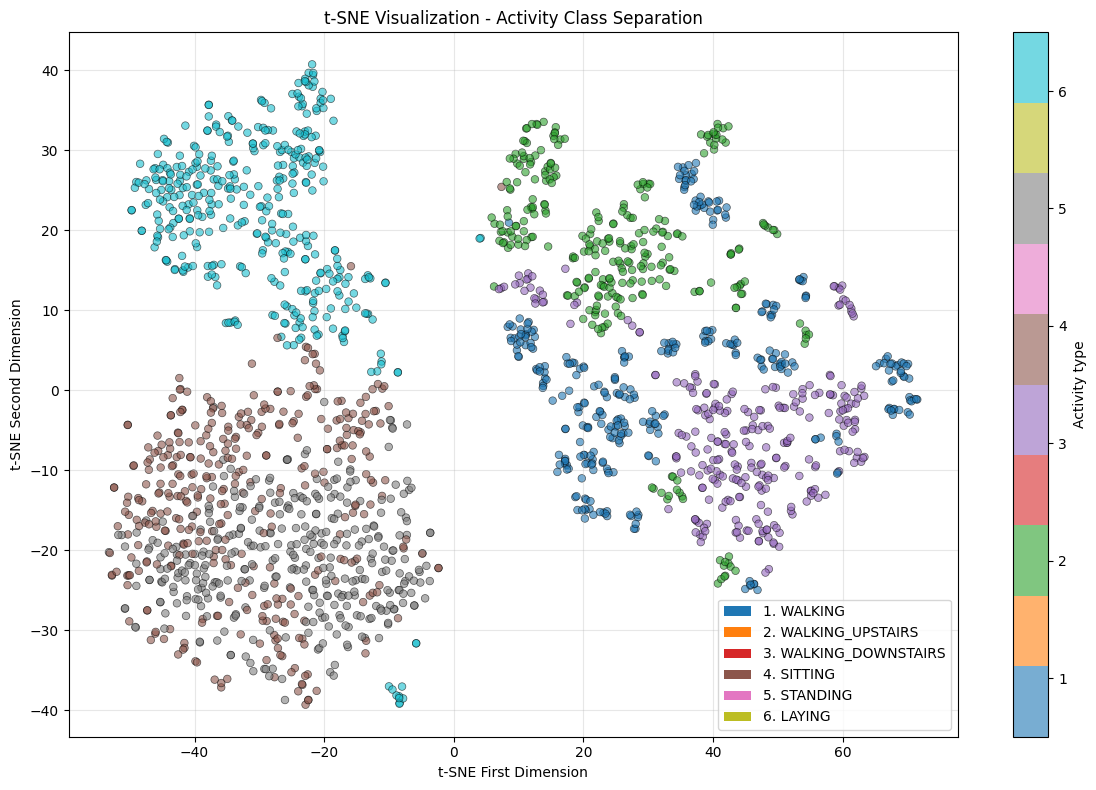

In [15]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                      c=y_train_sample, cmap='tab10', 
                      alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Add legend with activity names
activity_names_list = [activity_labels[activity_labels['code'] == i]['activity'].values[0] 
                       for i in sorted(y_train['Activity'].unique())]
plt.colorbar(scatter, label='Activity type', ticks=range(1, 7))
plt.clim(0.5, 6.5)

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=plt.cm.tab10(i/6), label=f'{i+1}. {activity_names_list[i]}') 
                   for i in range(6)]
plt.legend(handles=legend_elements, loc='best', fontsize=10)

plt.title('t-SNE Visualization - Activity Class Separation')
plt.xlabel('t-SNE First Dimension')
plt.ylabel('t-SNE Second Dimension')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_visualization.pdf', bbox_inches='tight')
plt.show()


## Performance comparison without and with PCA

In [16]:
import time

# Define a simple model for comparison (SVM with default parameters)
print("\n Without PCA...")
start_time = time.time()
svm_no_pca = SVC(kernel='rbf', random_state=33, C=1, gamma='scale')
svm_no_pca.fit(X_train_scaled, y_train['Activity'])
time_no_pca = time.time() - start_time
y_pred_no_pca = svm_no_pca.predict(X_test_scaled)
acc_no_pca = accuracy_score(y_test['Activity'], y_pred_no_pca)
f1_no_pca = f1_score(y_test['Activity'], y_pred_no_pca, average='weighted')

print(f" Training time: {time_no_pca:.2f} seconds")
print(f" Accuracy: {acc_no_pca:.4f}")
print(f" F1-Score: {f1_no_pca:.4f}")

print("\n PCA...")
start_time = time.time()
svm_with_pca = SVC(kernel='rbf', random_state=33, C=1, gamma='scale')
svm_with_pca.fit(X_train_pca, y_train['Activity'])
time_with_pca = time.time() - start_time
y_pred_with_pca = svm_with_pca.predict(X_test_pca)
acc_with_pca = accuracy_score(y_test['Activity'], y_pred_with_pca)
f1_with_pca = f1_score(y_test['Activity'], y_pred_with_pca, average='weighted')

print(f" Training time: {time_with_pca:.2f} seconds")
print(f" Accuracy: {acc_with_pca:.4f}")
print(f" F1-Score: {f1_with_pca:.4f}")


 Without PCA...
 Training time: 6.00 seconds
 Accuracy: 0.9522
 F1-Score: 0.9521

 PCA...
 Training time: 0.83 seconds
 Accuracy: 0.9379
 F1-Score: 0.9378


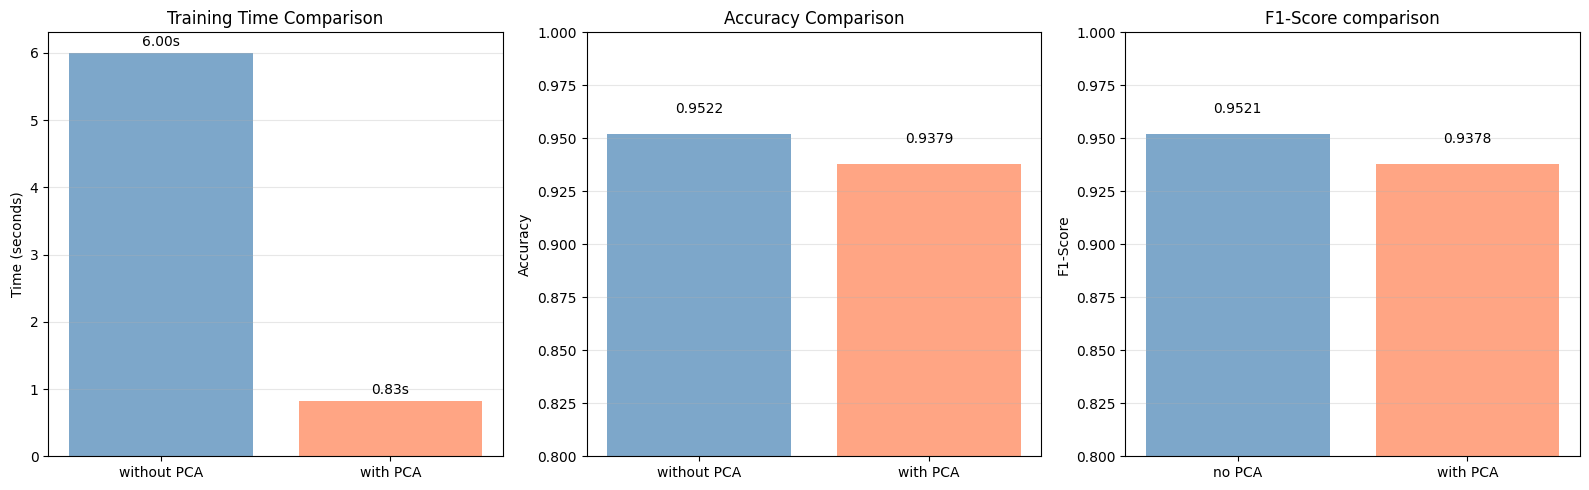

In [17]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Training time chart
axes[0].bar(['without PCA', 'with PCA'], [time_no_pca, time_with_pca],
            color=['steelblue', 'coral'], alpha=0.7)
axes[0].set_title('Training Time Comparison')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([time_no_pca, time_with_pca]):
    axes[0].text(i, v + 0.1, f'{v:.2f}s', ha='center')

# Accuracy chart
axes[1].bar(['without PCA', 'with PCA'], [acc_no_pca, acc_with_pca],
            color=['steelblue', 'coral'], alpha=0.7)
axes[1].set_title('Accuracy Comparison')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([acc_no_pca, acc_with_pca]):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

# F1-Score chart
axes[2].bar(['no PCA', 'with PCA'], [f1_no_pca, f1_with_pca], 
            color=['steelblue', 'coral'], alpha=0.7)
axes[2].set_title('F1-Score comparison')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim([0.8, 1.0])
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate([f1_no_pca, f1_with_pca]): 
    axes[2].text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('pca_comparison.pdf', bbox_inches='tight')
plt.show()

## Training SVM

In [18]:
# Define search parameters
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

print(f" Number of possible combinations: {len(param_grid_svm['C']) * len(param_grid_svm['gamma'])}")

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# GridSearchCV
grid_svm = GridSearchCV(
    SVC(random_state=33),
    param_grid_svm,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_svm.fit(X_train_pca, y_train['Activity'])
svm_training_time = time.time() - start_time

print(f"\n Total training time: {svm_training_time:.2f} seconds")
print(f" Best parameters: {grid_svm.best_params_}")
print(f" Best Cross-Validation accuracy: {grid_svm.best_score_:.4f}")

# Evaluation on Test Set
y_pred_svm = grid_svm.predict(X_test_pca)
svm_test_accuracy = accuracy_score(y_test['Activity'], y_pred_svm)
svm_test_f1 = f1_score(y_test['Activity'], y_pred_svm, average='weighted')

print(f" Accuracy on Test Set: {svm_test_accuracy:.4f}")
print(f" F1-Score on Test Set: {svm_test_f1:.4f}")


 Number of possible combinations: 20
Fitting 5 folds for each of 20 candidates, totalling 100 fits



 Total training time: 252.54 seconds
 Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
 Best Cross-Validation accuracy: 0.9801
 Accuracy on Test Set: 0.9393
 F1-Score on Test Set: 0.9391


In [19]:
# Show Classification Report for SVM
print("Classification Report - SVM")
target_names = [activity_labels[activity_labels['code'] == i]['activity'].values[0] 
    for i in sorted(y_test['Activity'].unique())]
print(classification_report(y_test['Activity'], y_pred_svm, target_names=target_names))

Classification Report - SVM
                    precision    recall  f1-score   support

           WALKING       0.95      0.97      0.96       496
  WALKING_UPSTAIRS       0.90      0.93      0.92       471
WALKING_DOWNSTAIRS       0.95      0.90      0.92       420
           SITTING       0.94      0.88      0.91       491
          STANDING       0.90      0.95      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



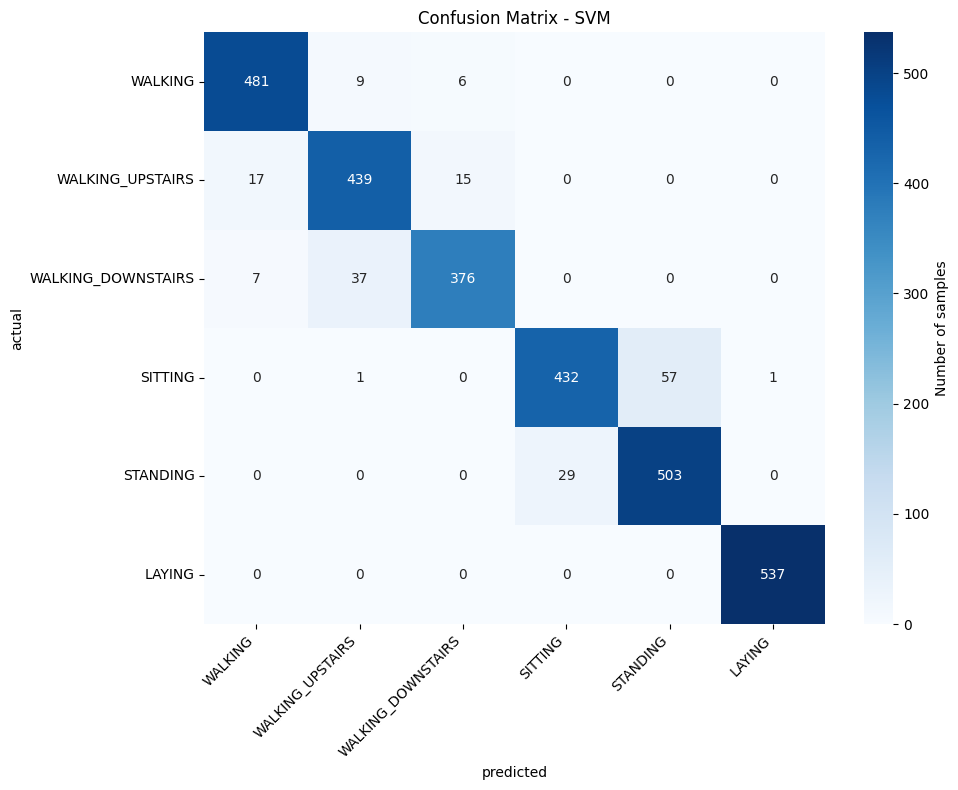

In [20]:
# Confusion Matrix - SVM
cm_svm = confusion_matrix(y_test['Activity'], y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Number of samples'})
plt.title('Confusion Matrix - SVM')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_svm.pdf', bbox_inches='tight')
plt.show()


In [21]:
# Analysis of important mistakes

print("SVM Error Analysis")
# Calculate the error rate for each pair of classes
print("\n Most errors between classes:")
mistakes = []
for i in range(len(cm_svm)):
    for j in range(len(cm_svm)):
        if i != j and cm_svm[i, j] > 0:
            mistakes.append({
                'from': target_names[i],
                'to': target_names[j],
                'number': cm_svm[i, j],
                'Percentage of total': f"{cm_svm[i, j] / cm_svm[i].sum() * 100:.1f}%"
            })

mistakes_df = pd.DataFrame(mistakes).sort_values('number', ascending=False)
print(mistakes_df.head(10).to_string(index=False))


SVM Error Analysis

 Most errors between classes:
              from                 to  number Percentage of total
           SITTING           STANDING      57               11.6%
WALKING_DOWNSTAIRS   WALKING_UPSTAIRS      37                8.8%
          STANDING            SITTING      29                5.5%
  WALKING_UPSTAIRS            WALKING      17                3.6%
  WALKING_UPSTAIRS WALKING_DOWNSTAIRS      15                3.2%
           WALKING   WALKING_UPSTAIRS       9                1.8%
WALKING_DOWNSTAIRS            WALKING       7                1.7%
           WALKING WALKING_DOWNSTAIRS       6                1.2%
           SITTING   WALKING_UPSTAIRS       1                0.2%
           SITTING             LAYING       1                0.2%


## MLP model training (neural network)

In [22]:
# Define search parameters
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 75, 30)],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate_init': [0.001, 0.01]
}

print(f" Number of possible combinations: {len(param_grid_mlp['hidden_layer_sizes']) * len(param_grid_mlp['alpha']) * len(param_grid_mlp['learning_rate_init'])}")
# RandomizedSearchCV for more speed
from sklearn.model_selection import RandomizedSearchCV

random_mlp = RandomizedSearchCV(
    MLPClassifier(max_iter=500, random_state=33, early_stopping=True, validation_fraction=0.1),
    param_grid_mlp,
    n_iter=10,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=33
)

start_time = time.time()
random_mlp.fit(X_train_pca, y_train['Activity'])
mlp_training_time = time.time() - start_time

print(f"\n Total training time: {mlp_training_time:.2f} seconds")
print(f" Best parameters: {random_mlp.best_params_}")
print(f" Best Cross-Validation accuracy: {random_mlp.best_score_:.4f}")

# Evaluation on Test Set
y_pred_mlp = random_mlp.predict(X_test_pca)
mlp_test_accuracy = accuracy_score(y_test['Activity'], y_pred_mlp)
mlp_test_f1 = f1_score(y_test['Activity'], y_pred_mlp, average='weighted')

print(f" Accuracy on Test Set: {mlp_test_accuracy:.4f}")
print(f" F1-Score on Test Set: {mlp_test_f1:.4f}")


 Number of possible combinations: 18
Fitting 5 folds for each of 10 candidates, totalling 50 fits

 Total training time: 51.53 seconds
 Best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (150, 75, 30), 'alpha': 0.001}
 Best Cross-Validation accuracy: 0.9772
 Accuracy on Test Set: 0.9427
 F1-Score on Test Set: 0.9425


In [23]:
# Show Classification Report for MLP
print("Classification Report - MLP")
print(classification_report(y_test['Activity'], y_pred_mlp, target_names=target_names))

Classification Report - MLP
                    precision    recall  f1-score   support

           WALKING       0.95      0.98      0.97       496
  WALKING_UPSTAIRS       0.92      0.94      0.93       471
WALKING_DOWNSTAIRS       0.95      0.90      0.93       420
           SITTING       0.94      0.87      0.90       491
          STANDING       0.89      0.95      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



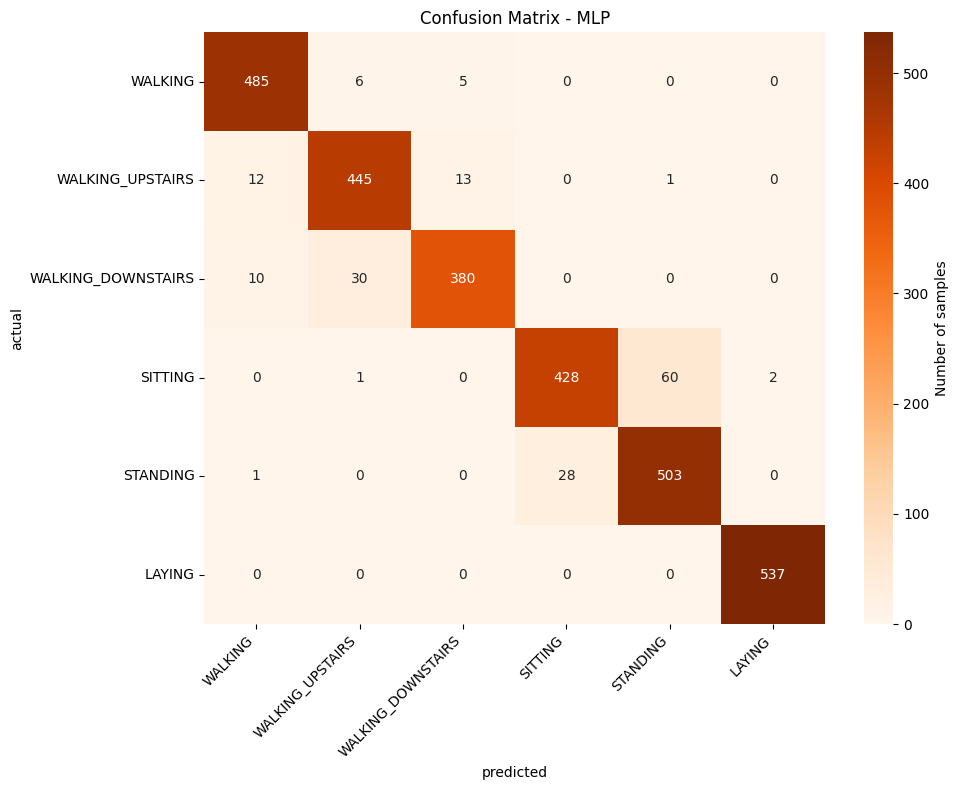

In [24]:
# Draw Confusion Matrix for MLP
cm_mlp = confusion_matrix(y_test['Activity'], y_pred_mlp)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Number of samples'})
plt.title('Confusion Matrix - MLP')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_mlp.pdf',bbox_inches='tight')
plt.show()



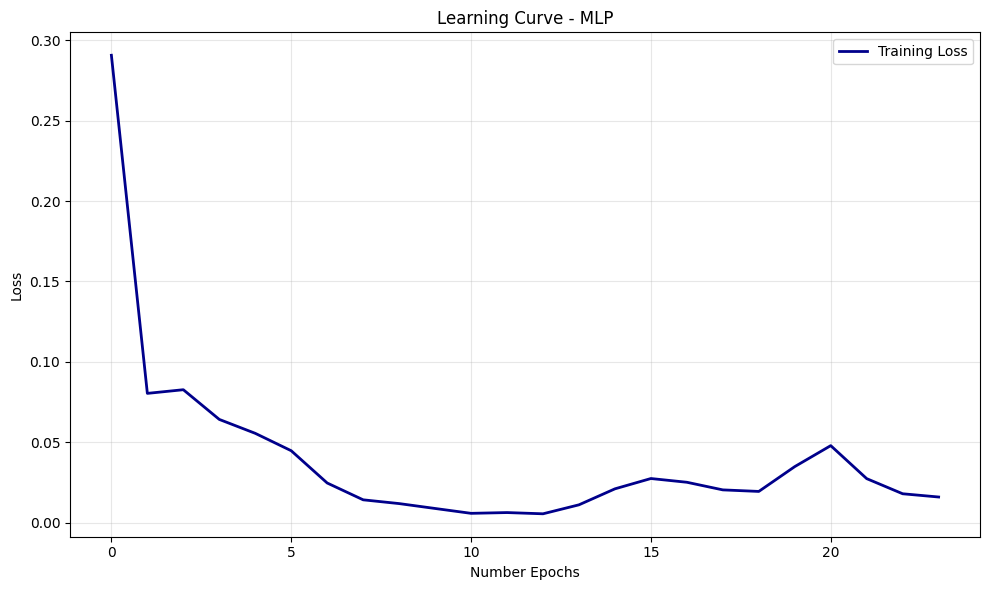


 Overfitting check:
 Accuracy on Train: 0.9966
 Accuracy on Test: 0.9427
 Difference: 0.0539 (5.39%)
The model generalizes well


In [25]:
# Review the Learning Curve for MLP
# Retrain with the best parameters and save loss
best_mlp = MLPClassifier(**random_mlp.best_params_, max_iter=500, random_state=33, early_stopping=False)
best_mlp.fit(X_train_pca, y_train['Activity'])

# Learning Curve Drawing
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_, linewidth=2, color='darkblue', label='Training Loss')
plt.title('Learning Curve - MLP')
plt.xlabel('Number Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('learning_curve_mlp.pdf', bbox_inches='tight')
plt.show()


# Overfitting check
train_pred_mlp = best_mlp.predict(X_train_pca)
train_accuracy_mlp = accuracy_score(y_train['Activity'], train_pred_mlp)

print(f"\n Overfitting check:")
print(f" Accuracy on Train: {train_accuracy_mlp:.4f}")
print(f" Accuracy on Test: {mlp_test_accuracy:.4f}")
print(f" Difference: {train_accuracy_mlp - mlp_test_accuracy:.4f} ({(train_accuracy_mlp - mlp_test_accuracy)*100:.2f}%)")

if train_accuracy_mlp - mlp_test_accuracy > 0.06:
    print("There is a possibility of overfitting")
else:
    print("The model generalizes well")


## Final comparison of models

In [26]:
results_data = {
    'Model': ['SVM', 'MLP'],
    'ACC Train': [accuracy_score(y_train['Activity'], grid_svm.predict(X_train_pca)), train_accuracy_mlp],
    'ACC Test': [svm_test_accuracy, mlp_test_accuracy],
    'F1-Score Test': [svm_test_f1, mlp_test_f1],
    'Training time (seconds)': [svm_training_time, mlp_training_time],
    'Difference Train-Test': [
        accuracy_score(y_train['Activity'], grid_svm.predict(X_train_pca)) - svm_test_accuracy,
        train_accuracy_mlp - mlp_test_accuracy
    ]
}

results_df = pd.DataFrame(results_data)

print("\n Model comparison table:")
print(results_df.to_string(index=False))



 Model comparison table:
Model  ACC Train  ACC Test  F1-Score Test  Training time (seconds)  Difference Train-Test
  SVM    0.99864  0.939260       0.939123               252.543273               0.059380
  MLP    0.99660  0.942654       0.942457                51.529071               0.053946


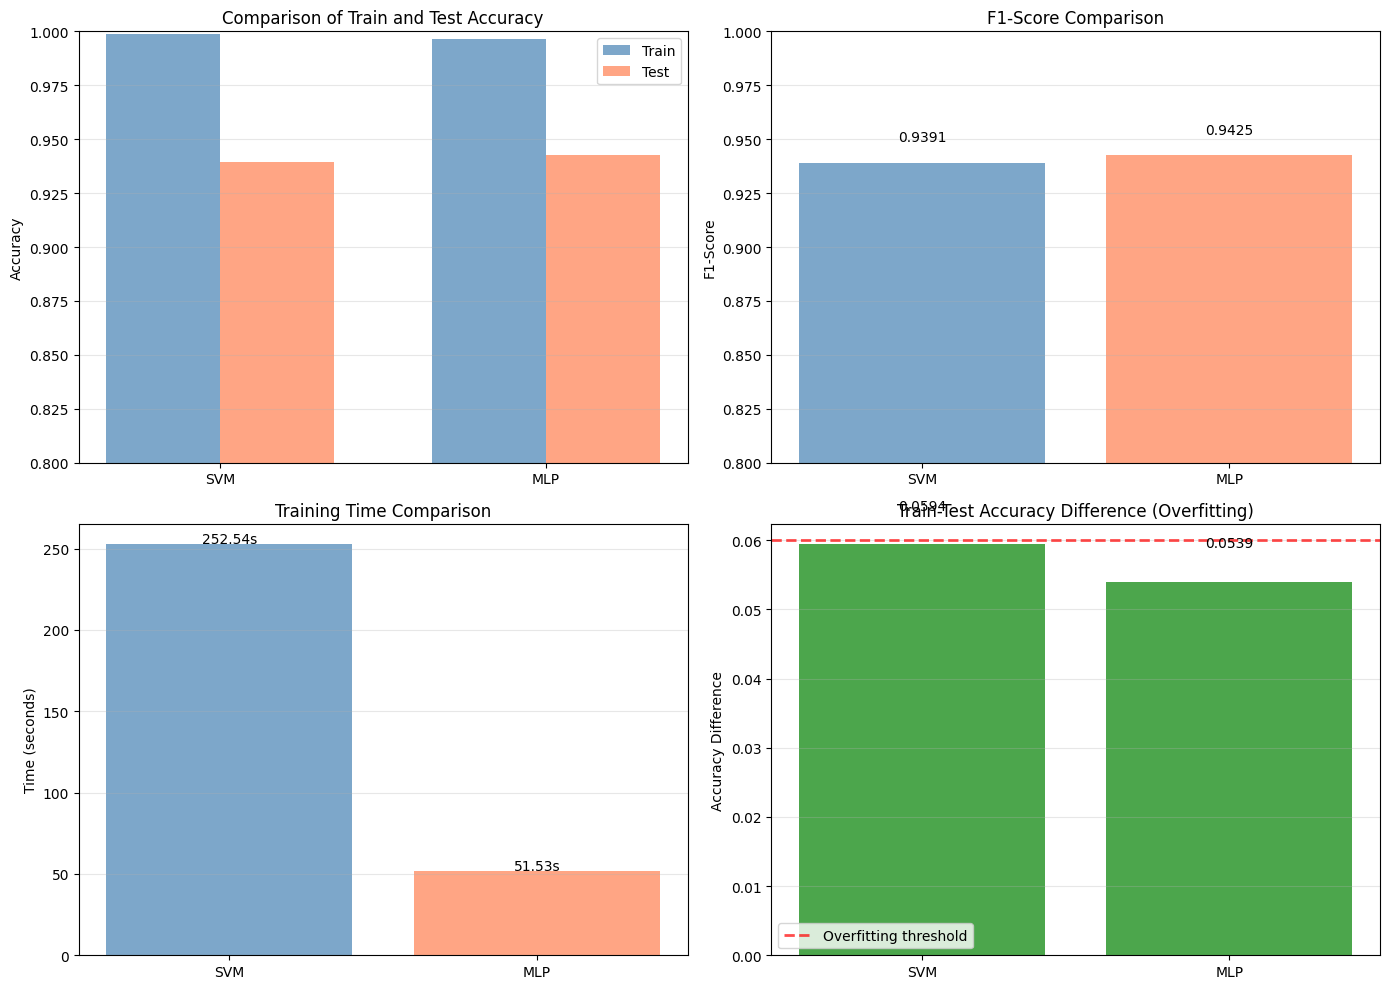

In [27]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = ['SVM', 'MLP']
train_accs = results_df['ACC Train'].values
test_accs = results_df['ACC Test'].values
f1_scores = results_df['F1-Score Test'].values
train_times = results_df['Training time (seconds)'].values

# Train vs Test accuracy chart
x = np.arange(len(models))
width = 0.35
axes[0, 0].bar(x - width/2, train_accs, width, label='Train', color='steelblue', alpha=0.7)
axes[0, 0].bar(x + width/2, test_accs, width, label='Test', color='coral', alpha=0.7)
axes[0, 0].set_title('Comparison of Train and Test Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0.8, 1.0])

# F1-Score chart
axes[0, 1].bar(models, f1_scores, color=['steelblue', 'coral'], alpha=0.7)
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0.8, 1.0])
for i, v in enumerate(f1_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center')

# Training time chart
axes[1, 0].bar(models, train_times, color=['steelblue', 'coral'], alpha=0.7)
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_times):
    axes[1, 0].text(i, v + 1, f'{v:.2f}s', ha='center')

# Train-Test difference graph (Overfitting)
overfit_diff = results_df['Difference Train-Test'].values
colors = ['green' if x < 0.06 else 'orange' for x in overfit_diff]
axes[1, 1].bar(models, overfit_diff, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0.06, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Overfitting threshold')
axes[1, 1].set_title('Train-Test Accuracy Difference (Overfitting)')
axes[1, 1].set_ylabel('Accuracy Difference')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].legend()
for i, v in enumerate(overfit_diff):
    axes[1, 1].text(i, v + 0.005, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('final_model_comparison.pdf',  bbox_inches='tight')
plt.show()



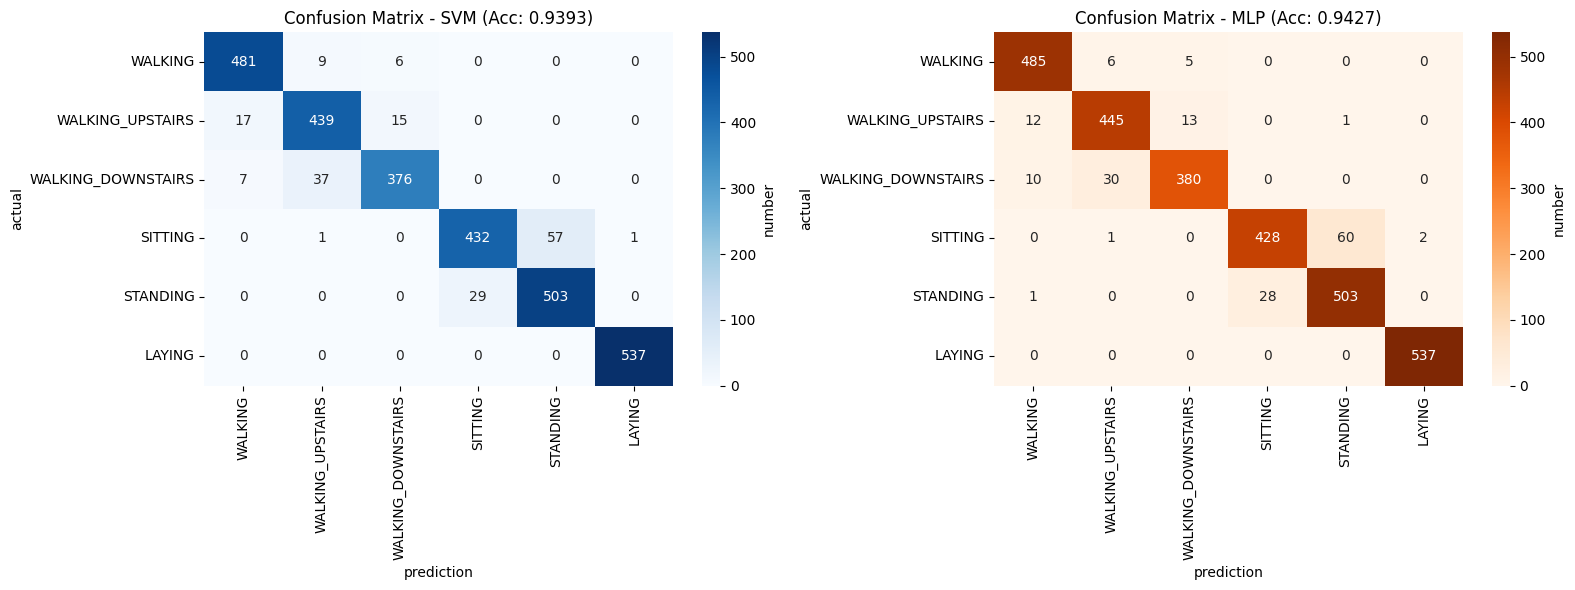

In [28]:
# Comparison of Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'number'})
axes[0].set_title(f'Confusion Matrix - SVM (Acc: {svm_test_accuracy:.4f})')
axes[0].set_xlabel('prediction')
axes[0].set_ylabel('actual')

# MLP
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'number'})
axes[1].set_title(f'Confusion Matrix - MLP (Acc: {mlp_test_accuracy:.4f})')
axes[1].set_xlabel('prediction')
axes[1].set_ylabel('actual')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.pdf', bbox_inches='tight')
plt.show()


## Deeper Analysis and Full Cross-Validation

In [31]:

print("Cross-Validation Analysis Complete")
# Cross-validation with 5-Fold

# SVM
cv_scores_svm = cross_val_score(grid_svm.best_estimator_, X_train_pca, y_train['Activity'], 
                                 cv=skf, scoring='accuracy', n_jobs=-1)
print(f"\n1. Cross-Validation Results - SVM:")
print(f" Average Accuracy: {cv_scores_svm.mean():.4f} (±{cv_scores_svm.std():.4f})")
print(f" Accuracy per Fold: {[f'{score:.4f}' for score in cv_scores_svm]}")

# MLP
cv_scores_mlp = cross_val_score(random_mlp.best_estimator_, X_train_pca, y_train['Activity'], 
                                 cv=skf, scoring='accuracy', n_jobs=-1)
print(f"\n2. Cross-Validation Results - MLP:")
print(f" Average Accuracy: {cv_scores_mlp.mean():.4f} (±{cv_scores_mlp.std():.4f})")
print(f" Accuracy per Fold: {[f'{score:.4f}' for score in cv_scores_mlp]}")


Cross-Validation Analysis Complete

1. Cross-Validation Results - SVM:
 Average Accuracy: 0.9801 (±0.0055)
 Accuracy per Fold: ['0.9789', '0.9708', '0.9803', '0.9837', '0.9871']

2. Cross-Validation Results - MLP:
 Average Accuracy: 0.9772 (±0.0051)
 Accuracy per Fold: ['0.9735', '0.9735', '0.9721', '0.9830', '0.9837']


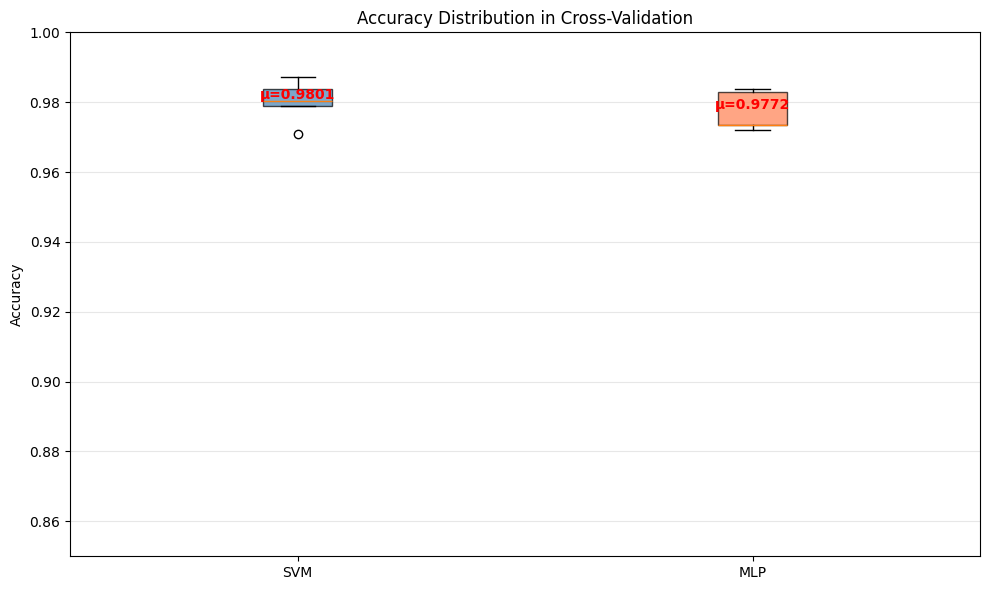

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

box_data = [cv_scores_svm, cv_scores_mlp]
bp = ax.boxplot(box_data, labels=['SVM', 'MLP'], patch_artist=True)

colors = ['steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('Accuracy Distribution in Cross-Validation')
ax.set_ylabel('Accuracy')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.85, 1.0])

# Add average
for i, scores in enumerate(box_data):
    ax.text(i+1, scores.mean(), f'μ={scores.mean():.4f}', 
            ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('cross_validation_comparison.pdf', bbox_inches='tight')
plt.show()


In [37]:

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score (Accuracy)")
    

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.savefig('Learning_Curve_cmlp.pdf', bbox_inches='tight')
    plt.show()

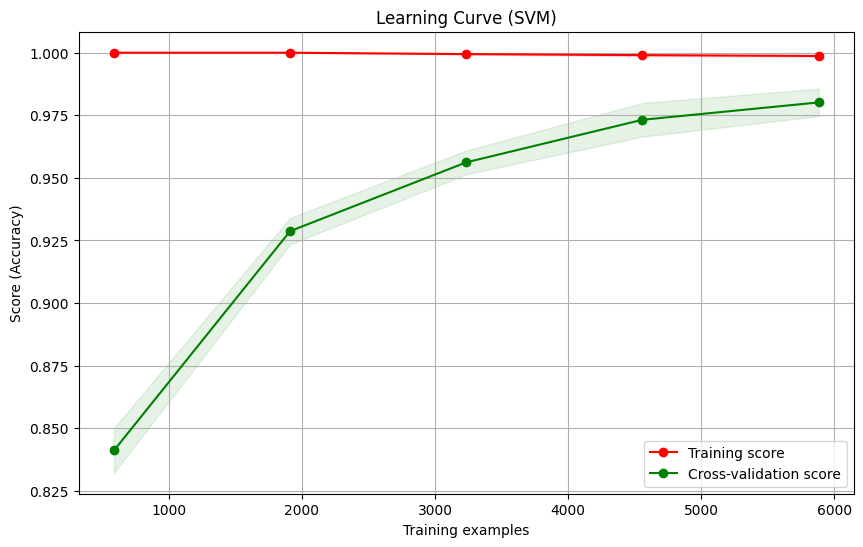

In [36]:
plot_learning_curve(grid_svm.best_estimator_, "Learning Curve (SVM)", X_train_pca, y_train['Activity'], cv=skf)

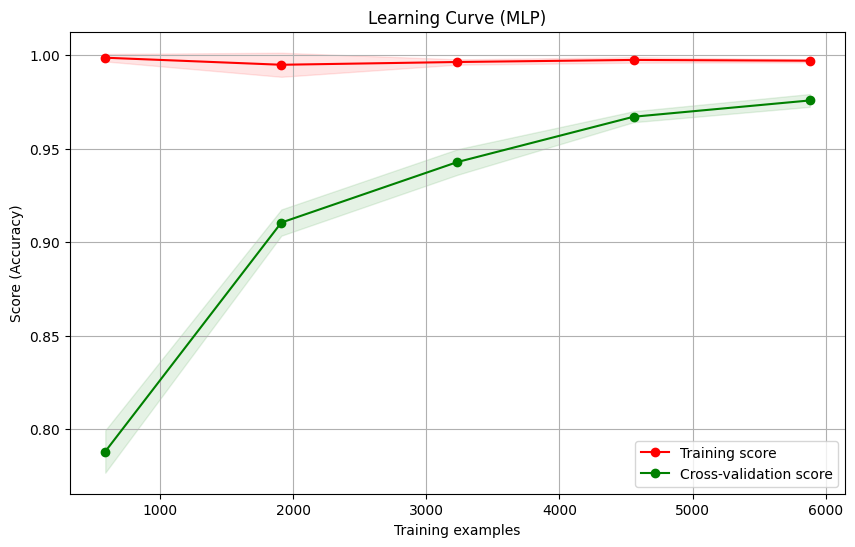

In [38]:
plot_learning_curve(random_mlp.best_estimator_, "Learning Curve (MLP)", X_train_pca, y_train['Activity'], cv=skf)